In [14]:
from SciDataTool import DataTime, Data1D, DataND

import numpy as np

from math import floor


In [15]:
import cvxpy as cp

import scipy.fft as spfft



### Implementation of the algorithm Orthogonal Matching Pursuit - OMP on a DataTime object

Given a DataTime object, build upon a non uniform axe Data1D (likely with Missing At Random - MAR samples), we want to compute the spectrum of the DataTime object. This assume that the signal has a sparse representation in the Fourier domain, that it's compressible.

There are 3 different way to implement this reconstruction:
1. Greedy algorithm -> OMP
2. Linear system with $l_1$ constraint
3. Combinatorial optimization (a bad idea in practice)


100


c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


TypeError: '<' not supported between instances of 'float' and 'NoneType'

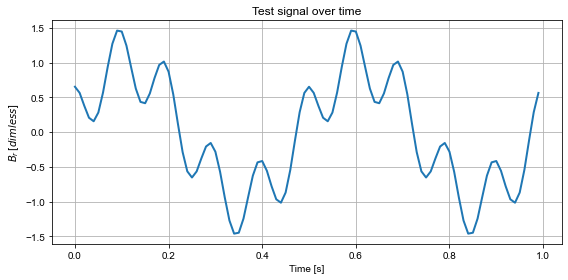

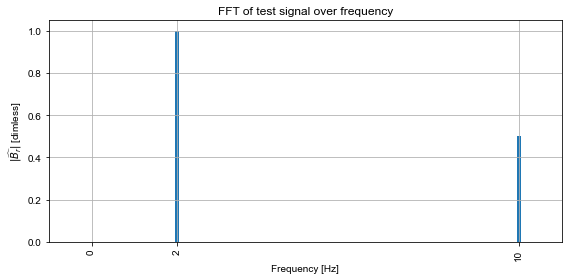

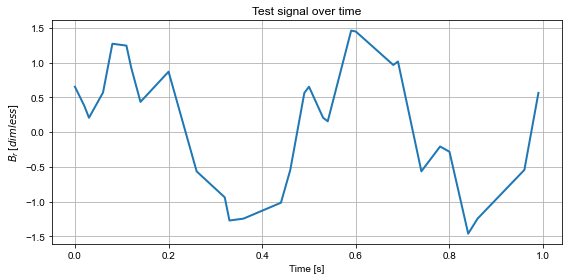

In [44]:
n = 100

t = np.linspace(0,1,n,endpoint=False)

print(len(t))

K = 0.30
m = floor(K*n)
M = np.random.choice(n,m, replace=False)
M.sort()

signal = np.sin(2*np.pi*2*t+0.2) + 0.5*np.sin(2*np.pi*10*t+2)
signal_under = signal[M]

Time = Data1D(name="time", unit="s", values=t)
Time_under = Data1D(name="time", unit="s", values=t[M])

Signal = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal,
    is_real=True,
)

Signal_under = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time_under],
    values=signal_under,
    is_real=True,
)
Signal.plot_2D_Data("time")

Signal.plot_2D_Data("freqs")

Signal_under.plot_2D_Data("time")
Signal_under.plot_2D_Data("freqs")




In [45]:
def omp(undersampled_signal,M,n):

    A = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
    A = A[M]

    vx = cp.Variable(n)
    objective = cp.Minimize(cp.norm(vx,1))
    constraints = [A @ vx == undersampled_signal]

    prob = cp.Problem(objective, constraints)

    result = prob.solve(verbose=False)

    # reconstruct signal
    x = np.array(vx.value)
    x = np.squeeze(x)
    sig = spfft.idct(x, type=2, norm='ortho', axis=0)

    return sig

c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


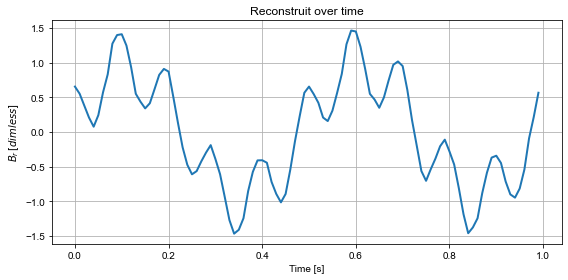

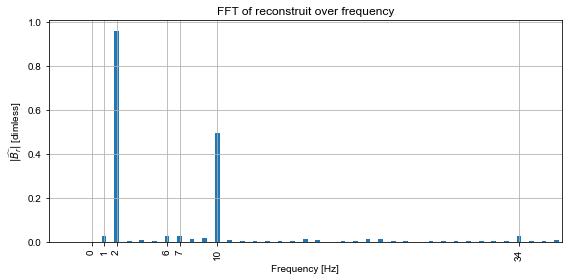

In [46]:


signal_reconstruit = omp(signal_under,M,n)

Signal_reconstruit = DataTime(
    name="reconstruit",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_reconstruit,
    is_real=True,
    )


Signal_reconstruit.plot_2D_Data("time")
Signal_reconstruit.plot_2D_Data("freqs")



In [47]:

from sklearn.linear_model import orthogonal_mp
from sklearn.decomposition import sparse_encode


In [62]:

def encode(signal_under,M,n):

    A = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
    A = A[M]
    A = A.T

    print(A.shape)
    print(signal_under.shape)

    signal_under = signal_under.reshape(-1,1)
    signal_under = signal_under.T

    print(signal_under.shape)

    res = sparse_encode(X=signal_under,dictionary=A,algorithm='omp')


    A_reconstruit = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)

    signal_reconstruit = res @ A_reconstruit.T

    return res, signal_reconstruit


res, signal_reconstruit = encode(signal_under,M,n)



(100, 30)
(30,)
(1, 30)


In [63]:
signal_reconstruit

array([[ 0.59584381,  0.43507456,  0.17773674, -0.07239892, -0.2118418 ,
        -0.17722376,  0.03009348,  0.34405638,  0.65860211,  0.86757311,
         0.90463473,  0.76796679,  0.52031647,  0.26441108,  0.10314078,
         0.09973753,  0.25317711,  0.4982141 ,  0.73004914,  0.84421625,
         0.77646183,  0.52738728,  0.16244364, -0.21272164, -0.49215414,
        -0.60949016, -0.56263375, -0.41380135, -0.26493272, -0.21787838,
        -0.3345901 , -0.61254071, -0.9847833 , -1.34464818, -1.5856651 ,
        -1.64148139, -1.51054717, -1.25615508, -0.9818335 , -0.79150391,
        -0.74962938, -0.85658158, -1.04863752, -1.22260591, -1.27567221,
        -1.14523496, -0.83350636, -0.40746674,  0.02582629,  0.35916116,
         0.52509934,  0.52067675,  0.40746674,  0.28700332,  0.26097446,
         0.39141171,  0.67610287,  1.04863752,  1.40308462,  1.63388988,
         1.67576441,  1.52833654,  1.25615508,  0.96404413,  0.75722089,
         0.7014046 ,  0.79814514,  0.9847833 ,  1.1

In [64]:
res.shape

(1, 100)

In [65]:
res[res != 0.]

array([ 5.34694752, -4.26724722,  3.28722103])

c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


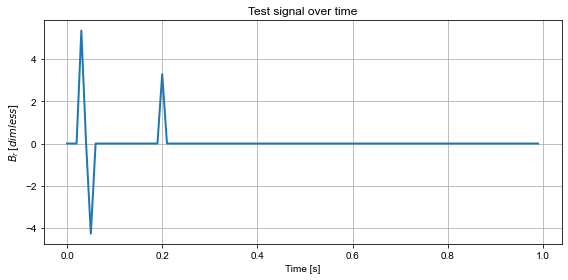

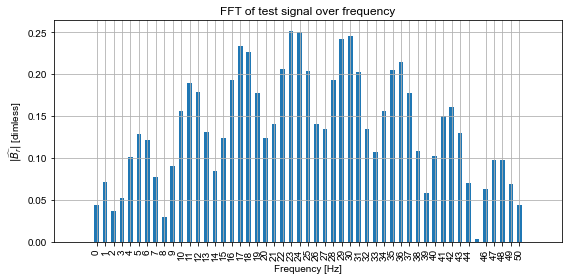

In [66]:

Signal_reconstruit = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=res,
    is_real=True,
)

Signal_reconstruit.plot_2D_Data("time")

Signal_reconstruit.plot_2D_Data("freqs")